<a href="https://colab.research.google.com/github/Mike-Xie/DS-Unit-2-Build-Week/blob/master/Mike_Xie_Unit_2_Build_Week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [0]:
!wget https://github.com/bowswung/voobly-scraper/raw/master/data/MatchData/20190208/matchDump.csv.zip

--2019-12-20 07:14:29--  https://github.com/bowswung/voobly-scraper/raw/master/data/MatchData/20190208/matchDump.csv.zip
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/bowswung/voobly-scraper/master/data/MatchData/20190208/matchDump.csv.zip [following]
--2019-12-20 07:14:29--  https://media.githubusercontent.com/media/bowswung/voobly-scraper/master/data/MatchData/20190208/matchDump.csv.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49029198 (47M) [application/zip]
Saving to: ‘matchDump.csv.zip.1’

matchDump.csv.zip.1 100%[===================>]  46.76M   154MB/s    in 0.3s   

In [0]:
!unzip matchDump.csv.zip

Archive:  matchDump.csv.zip
replace matchDump.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
!head matchDump.csv

MatchId,MatchUrl,MatchDate,MatchDuration,MatchLadder,MatchMap,MatchMods,MatchPlayerId,MatchPlayerName,MatchPlayerTeam,MatchPlayerCivId,MatchPlayerCivName,MatchPlayerWinner,MatchPlayerPreRating,MatchPlayerPostRating,MatchPlayerRecording
17827685,https://www.voobly.com/match/view/17827685,2018-05-27T18:14:00,520,Match Stats Only,=V= CBA Hero AC V13.scx,v1.5 Beta R6,123972487,___Oreo,1,9,Saracens,1,1584,1600,
17827685,https://www.voobly.com/match/view/17827685,2018-05-27T18:14:00,520,Match Stats Only,=V= CBA Hero AC V13.scx,v1.5 Beta R6,125049367,___Dm,2,9,Saracens,0,1616,1600,
17827728,https://www.voobly.com/match/view/17827728,2018-05-27T18:21:00,661,Match Stats Only,=V= CBA Hero AC V13.scx,v1.5 Beta R6,123972487,___Oreo,1,13,Celts,1,1584,1600,
17827728,https://www.voobly.com/match/view/17827728,2018-05-27T18:21:00,661,Match Stats Only,=V= CBA Hero AC V13.scx,v1.5 Beta R6,125049367,___Dm,2,13,Celts,0,1616,1600,
17832641,https://www.voobly.com/match/view/17832641,2018-05-28T11:25:00,762,

In [0]:
import pandas as pd

import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
pd.options.display.max_rows = 999
pd.options.display.max_columns = 100

df = pd.read_csv('matchDump.csv', header=0, engine='python')

cols_to_keep = ['MatchId','MatchMods','MatchMap','MatchLadder','MatchDuration','MatchPlayerTeam','MatchPlayerCivId','MatchPlayerCivName','MatchPlayerWinner','MatchPlayerPreRating']

df = df[cols_to_keep]

df.shape


(1263808, 10)

In [0]:
df.head(5)

MatchId     MatchMods                 MatchMap       MatchLadder  \
0  17827685  v1.5 Beta R6  =V= CBA Hero AC V13.scx  Match Stats Only   
1  17827685  v1.5 Beta R6  =V= CBA Hero AC V13.scx  Match Stats Only   
2  17827728  v1.5 Beta R6  =V= CBA Hero AC V13.scx  Match Stats Only   
3  17827728  v1.5 Beta R6  =V= CBA Hero AC V13.scx  Match Stats Only   
4  17832641  v1.5 Beta R6  =V= CBA Hero AC V13.scx  Match Stats Only   

   MatchDuration MatchPlayerTeam MatchPlayerCivId MatchPlayerCivName  \
0            520               1                9           Saracens   
1            520               2                9           Saracens   
2            661               1               13              Celts   
3            661               2               13              Celts   
4            762               1               14            Spanish   

  MatchPlayerWinner MatchPlayerPreRating  
0                 1                 1584  
1                 0                 1616  
2                 1                 1584  
3                 0                 1616  
4                 1                 1584

# Choose Target

In [0]:
# I want to predict which player wins

target = 'MatchPlayerWinner'

# This is 50/50 since odds are P1 and evens are P2 for a baseline

In [0]:
df[target].describe()

count     1263808
unique          3
top             0
freq       647589
Name: MatchPlayerWinner, dtype: object

In [0]:
df['MatchLadder'].value_counts()

RM - Team           723786
RM - 1v1            411718
Match Stats Only     81083
DM - Team            40249
DM - 1v1              6972
Name: MatchLadder, dtype: int64

In [0]:
# only do 1v1 on random map game mode

rm_1v1 = df[df['MatchLadder'] == 'RM - 1v1']

# remove ones with errors

rm_1v1 = rm_1v1[rm_1v1.MatchPlayerPreRating != '*VooblyErrorPlayerNotFound*']

# drop matchladder now since it's all the same

rm_1v1 = rm_1v1.drop(labels=['MatchLadder','MatchPlayerCivName','MatchPlayerTeam'], axis=1)

rm_1v1.head()

MatchId                     MatchMods MatchMap  MatchDuration  \
728  18658367  v1.5 Beta R7, WololoKingdoms   Arabia           1055   
729  18658367  v1.5 Beta R7, WololoKingdoms   Arabia           1055   
730  18658419                        1.4 RC   Custom           3361   
731  18658419                        1.4 RC   Custom           3361   
732  18658476  v1.5 Beta R7, WololoKingdoms    Nomad           3369   

    MatchPlayerCivId MatchPlayerWinner MatchPlayerPreRating  
728               16                 1                 1599  
729               11                 0                 1600  
730               18                 1                 1629  
731               17                 0                 1548  
732                6                 1                 1975

In [0]:
rm_1v1.dtypes

MatchId                  int64
MatchMods               object
MatchMap                object
MatchDuration            int64
MatchPlayerCivId        object
MatchPlayerWinner       object
MatchPlayerPreRating    object
dtype: object

In [0]:
rm_1v1['MatchPlayerCivId'] = rm_1v1['MatchPlayerCivId'].astype(int)
rm_1v1['MatchPlayerWinner'] = rm_1v1['MatchPlayerWinner'].astype(int)
rm_1v1['MatchPlayerPreRating'] = rm_1v1['MatchPlayerPreRating'].astype(int)

In [0]:
rm_1v1.dtypes 

MatchId                  int64
MatchMods               object
MatchMap                object
MatchDuration            int64
MatchPlayerCivId         int64
MatchPlayerWinner        int64
MatchPlayerPreRating     int64
dtype: object

In [0]:
rm_1v1['MatchMods'].describe()

count                           411632
unique                              40
top       v1.5 Beta R7, WololoKingdoms
freq                            293214
Name: MatchMods, dtype: object

In [0]:
rm_1v1['MatchMap'].describe()

count     411632
unique        57
top       Arabia
freq      274278
Name: MatchMap, dtype: object

In [0]:
rm_1v1.tail()

MatchId                     MatchMods MatchMap  MatchDuration  \
1263771  19250562  v1.5 Beta R7, WololoKingdoms   Arabia           4797   
1263772  19250571  v1.5 Beta R7, WololoKingdoms   Custom           2501   
1263773  19250571  v1.5 Beta R7, WololoKingdoms   Custom           2501   
1263774  19250581  v1.5 Beta R7, WololoKingdoms   Custom           4080   
1263775  19250581  v1.5 Beta R7, WololoKingdoms   Custom           4080   

         MatchPlayerCivId  MatchPlayerWinner  MatchPlayerPreRating  
1263771                 8                  0                  1695  
1263772                13                  1                  1933  
1263773                12                  0                  1909  
1263774                24                  1                  1542  
1263775                19                  0                  1479

In [0]:
y = rm_1v1[target]

y.nunique()

2

In [0]:
y.value_counts() # baseline is 50/50 since only P1 or P2 can win a 1v1

1    205816
0    205816
Name: MatchPlayerWinner, dtype: int64

In [0]:
# ask Shriphani how to drop Voobly Errors

In [0]:
# do this later to feature engineer relative rating by getting P1 and P2 ratings on same row after merge

first_players = rm_1v1[::2]
second_players = rm_1v1[1::2]


first_players.shape, second_players.shape

((205816, 7), (205816, 7))

In [0]:
first_players.head()

MatchId                     MatchMods MatchMap  MatchDuration  \
728  18658367  v1.5 Beta R7, WololoKingdoms   Arabia           1055   
730  18658419                        1.4 RC   Custom           3361   
732  18658476  v1.5 Beta R7, WololoKingdoms    Nomad           3369   
734  18658489                        1.4 RC   Custom           1891   
736  18658492  v1.5 Beta R7, WololoKingdoms   Custom           3832   

     MatchPlayerCivId  MatchPlayerWinner  MatchPlayerPreRating  
728                16                  1                  1599  
730                18                  1                  1629  
732                 6                  1                  1975  
734                12                  1                  1415  
736                22                  1                  1385

In [0]:
second_players.head()

MatchId                     MatchMods MatchMap  MatchDuration  \
729  18658367  v1.5 Beta R7, WololoKingdoms   Arabia           1055   
731  18658419                        1.4 RC   Custom           3361   
733  18658476  v1.5 Beta R7, WololoKingdoms    Nomad           3369   
735  18658489                        1.4 RC   Custom           1891   
737  18658492  v1.5 Beta R7, WololoKingdoms   Custom           3832   

     MatchPlayerCivId  MatchPlayerWinner  MatchPlayerPreRating  
729                11                  0                  1600  
731                17                  0                  1548  
733                17                  0                  2065  
735                18                  0                  1535  
737                 8                  0                  1600

In [0]:
p2_names = {
    "MatchPlayerCivId" : "MatchPlayerCivId2",
    "MatchPlayerPreRating" : "MatchPlayerPreRating2",
    "MatchPlayerPostRating" : "MatchPlayerPostRating2"
}

second_players = second_players.rename(columns=p2_names)

drop_cols = ['MatchMods','MatchDuration','MatchPlayerWinner', 'MatchMap']
second_players = second_players.drop(labels=drop_cols, axis=1)

second_players.head()

MatchId  MatchPlayerCivId2  MatchPlayerPreRating2
729  18658367                 11                   1600
731  18658419                 17                   1548
733  18658476                 17                   2065
735  18658489                 18                   1535
737  18658492                  8                   1600

In [0]:
rm_1v1 = first_players.merge(second_players, on='MatchId')


In [0]:
# set matchID as index

rm_1v1 = rm_1v1.set_index('MatchId')

# unfortunately all of the entries are formatted such that P1 is the match winner so we need to shuffle some
# half of it




In [0]:
from sklearn.model_selection import train_test_split

fst, snd = train_test_split(rm_1v1, train_size=0.5, test_size=0.5)

fst.shape, snd.shape

snd_names = {
    "MatchPlayerCivId" : "MatchPlayerCivId2",
    "MatchPlayerPreRating" : "MatchPlayerPreRating2",
    "MatchPlayerPostRating" : "MatchPlayerPostRating2",
    "MatchPlayerCivId2" : "MatchPlayerCivId",
    "MatchPlayerPreRating2" : "MatchPlayerPreRating",
    "MatchPlayerPostRating2" : "MatchPlayerPostRating"
}

snd = snd.rename(columns=snd_names)
snd['MatchPlayerWinner'] = snd['MatchPlayerWinner'].map({1:0})

snd = snd.fillna(0)

snd.head()


MatchMods MatchMap  MatchDuration  \
MatchId                                                          
18908910                  v1.5 Beta R7   Custom           3198   
19047033  v1.5 Beta R7, WololoKingdoms   Arabia           1893   
19082891  v1.5 Beta R7, WololoKingdoms   Custom           1094   
19207723  v1.5 Beta R7, WololoKingdoms   Custom           1818   
18894597  v1.5 Beta R7, WololoKingdoms   Arabia           1401   

          MatchPlayerCivId2  MatchPlayerWinner  MatchPlayerPreRating2  \
MatchId                                                                 
18908910                 10                  0                   1468   
19047033                 15                  0                   1555   
19082891                  2                  0                   2013   
19207723                 26                  0                   1445   
18894597                  2                  0                   1681   

          MatchPlayerCivId  MatchPlayerPreRating  
MatchId                                           
18908910                18                  1581  
19047033                10                  1596  
19082891                19                  2190  
19207723                10                  1577  
18894597                14                  1552

In [0]:
fst.head()

MatchMods MatchMap  MatchDuration  \
MatchId                                                          
18799335                  v1.5 Beta R7   Arabia           2927   
18919324                  v1.5 Beta R7    Nomad           1973   
18889235  v1.5 Beta R7, WololoKingdoms   Arabia           3025   
18961453  v1.5 Beta R7, WololoKingdoms   Arabia           4020   
19006161                  v1.5 Beta R7   Arabia           2438   

          MatchPlayerCivId  MatchPlayerWinner  MatchPlayerPreRating  \
MatchId                                                               
18799335                18                  1                  1690   
18919324                 7                  1                  1697   
18889235                28                  1                  1537   
18961453                10                  1                  1652   
19006161                17                  1                  1607   

          MatchPlayerCivId2  MatchPlayerPreRating2  
MatchId                                             
18799335                 16                   1667  
18919324                  1                   1600  
18889235                 25                   1482  
18961453                  8                   1641  
19006161                 17                   1675

In [0]:
rm_1v1 = snd.append(fst, sort=True)

# Feature Engineering 

In [0]:
rm_1v1['EloDifference'] = rm_1v1['MatchPlayerPreRating'] - rm_1v1['MatchPlayerPreRating2']

rm_1v1.head()

MatchDuration MatchMap                     MatchMods  \
MatchId                                                          
18908910           3198   Custom                  v1.5 Beta R7   
19047033           1893   Arabia  v1.5 Beta R7, WololoKingdoms   
19082891           1094   Custom  v1.5 Beta R7, WololoKingdoms   
19207723           1818   Custom  v1.5 Beta R7, WololoKingdoms   
18894597           1401   Arabia  v1.5 Beta R7, WololoKingdoms   

          MatchPlayerCivId  MatchPlayerCivId2  MatchPlayerPreRating  \
MatchId                                                               
18908910                18                 10                  1581   
19047033                10                 15                  1596   
19082891                19                  2                  2190   
19207723                10                 26                  1577   
18894597                14                  2                  1552   

          MatchPlayerPreRating2  MatchPlayerWinner  EloDifference  
MatchId                                                            
18908910                   1468                  0            113  
19047033                   1555                  0             41  
19082891                   2013                  0            177  
19207723                   1445                  0            132  
18894597                   1681                  0           -129

In [0]:
rm_1v1.columns

Index(['MatchDuration', 'MatchMap', 'MatchMods', 'MatchPlayerCivId',
       'MatchPlayerCivId2', 'MatchPlayerPreRating', 'MatchPlayerPreRating2',
       'MatchPlayerWinner', 'EloDifference'],
      dtype='object')

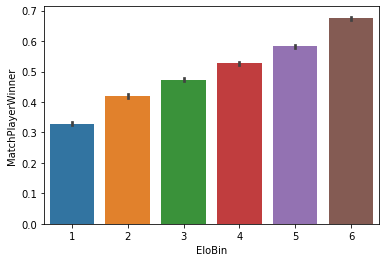

In [0]:
rm_1v1['EloBin'] = pd.qcut(rm_1v1['EloDifference'], 6, labels=[1,2,3,4,5,6])

sns.barplot(x='EloBin', y='MatchPlayerWinner', data=rm_1v1);

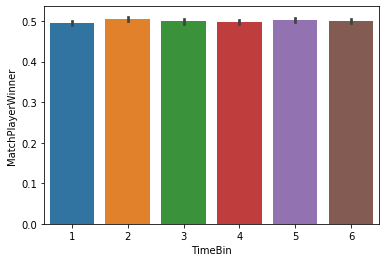

In [0]:
rm_1v1['TimeBin'] = pd.qcut(rm_1v1['MatchDuration'], 6, labels=[1,2,3,4,5,6])

sns.barplot(x='TimeBin', y='MatchPlayerWinner', data=rm_1v1);

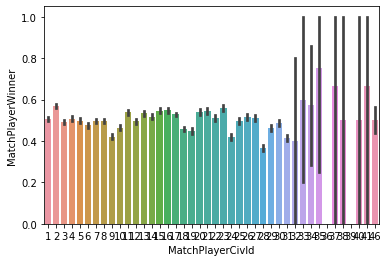

In [0]:
sns.barplot(x='MatchPlayerCivId', y='MatchPlayerWinner', data=rm_1v1); 

# ok prob bin some of the less popular ones together



In [0]:
rm_1v1['MatchPlayerCivId'].value_counts()

17    15442
12     8185
13     7902
7      7883
16     7870
2      7822
15     7800
11     7739
1      7675
14     7533
18     7522
6      7493
5      7480
4      7480
3      7449
10     7316
9      7281
8      7255
26     4790
23     4787
22     4781
20     4712
21     4689
19     4642
27     4638
28     4604
29     4584
24     4571
31     4559
30     4556
25     4501
46      241
34        7
33        5
32        5
35        4
41        3
37        3
38        2
39        2
40        2
36        1
Name: MatchPlayerCivId, dtype: int64

In [0]:
rm_1v1.columns

Index(['MatchDuration', 'MatchMap', 'MatchMods', 'MatchPlayerCivId',
       'MatchPlayerCivId2', 'MatchPlayerPreRating', 'MatchPlayerPreRating2',
       'MatchPlayerWinner', 'EloDifference', 'EloBin'],
      dtype='object')

In [0]:
rm_1v1.head()

MatchDuration MatchMap                     MatchMods  \
MatchId                                                          
18908910           3198   Custom                  v1.5 Beta R7   
19047033           1893   Arabia  v1.5 Beta R7, WololoKingdoms   
19082891           1094   Custom  v1.5 Beta R7, WololoKingdoms   
19207723           1818   Custom  v1.5 Beta R7, WololoKingdoms   
18894597           1401   Arabia  v1.5 Beta R7, WololoKingdoms   

          MatchPlayerCivId  MatchPlayerCivId2  MatchPlayerPreRating  \
MatchId                                                               
18908910                18                 10                  1581   
19047033                10                 15                  1596   
19082891                19                  2                  2190   
19207723                10                 26                  1577   
18894597                14                  2                  1552   

          MatchPlayerPreRating2  MatchPlayerWinner  EloDifference  \
MatchId                                                             
18908910                   1468                  0            113   
19047033                   1555                  0             41   
19082891                   2013                  0            177   
19207723                   1445                  0            132   
18894597                   1681                  0           -129   

                      EloBin  
MatchId                       
18908910      (77.0, 1005.0]  
19047033        (32.0, 77.0]  
19082891      (77.0, 1005.0]  
19207723      (77.0, 1005.0]  
18894597  (-1007.001, -77.0]

# FIT MODEL

In [0]:
rm_1v1.describe()

from sklearn.model_selection import train_test_split

train, val = train_test_split(rm_1v1, train_size = 0.8, test_size = 0.2)

train.shape, val.shape

((164652, 10), (41164, 10))

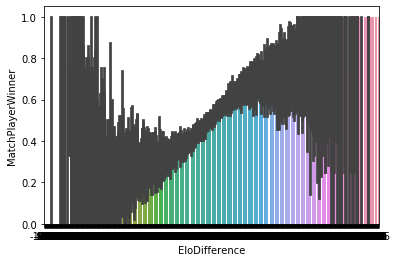

In [0]:
import seaborn as sns

sns.barplot(x='EloDifference', y='MatchPlayerWinner', data=rm_1v1);

In [0]:
# run a model better than baseline 
target = 'MatchPlayerWinner'
features = [
            'MatchMods', 
            'MatchMap', 
            'MatchDuration',
      #  'MatchPlayerCivId', 
       # 'MatchPlayerPreRating',
     #   'MatchPlayerCivId2', 
       # 'MatchPlayerPreRating2',
        'EloDifference', 
        'EloBin']
# looks sparse need to make a lot of feature engineering later
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]


# Train Accuracy 1.0 Still Not Sure Why

In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    #RandomForestClassifier(n_estimators = 100, n_jobs=-1)
    DecisionTreeClassifier(random_state=42)
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)

print('Train Accuracy', pipeline.score(X_train, y_train))

# well, that's, not good

Train Accuracy 0.9869968175303063


In [0]:
print('Validation Accuracy', pipeline.score(X_val, y_val))

# fail

Validation Accuracy 0.5293460305120979


In [0]:
rm_1v1['EloDifference'].describe()

# Visualization of Random Forest See Why It Fails

In [0]:
# import graphviz
# from sklearn.tree import export_graphviz

# model = pipeline.named_steps['decisiontreeclassifier']
# encoder = pipeline.named_steps['ordinalencoder']
# encoded_columns = encoder.transform(X_val).columns



# dot_data = export_graphviz(model, 
#                            out_file=None, 
#                            max_depth=3, 
#                            feature_names=encoded_columns,
#                            class_names=model.classes_, 
#                            impurity=False, 
#                            filled=True, 
#                            proportion=True, 
#                            rounded=True)   
# display(graphviz.Source(dot_data))

# # not sure why suddenly broken

# Wednesday XBG Boost 

In [0]:
rf = pipeline.named_steps['decisiontreeclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n=20

plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

# Thursday PDP and Shapely Plots

In [0]:
sns.distplot(y_train);

In [0]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lr = make_pipeline(
    ce.TargetEncoder(),  
    LinearRegression()
)

lr.fit(X_train, y_train)
print('Linear Regression R^2', lr.score(X_val, y_val))

In [0]:
# oh god these coeffficients are so low

from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

In [0]:
# increase the dots per inch (double it), so the text isn't so fuzzy
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [0]:
if 'google.colab' in sys.modules:

      !pip install pdpbox
      !pip install shap

from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'EloDifference'

isolated = pdp_isolate(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature)

In [0]:
# Plot PDP with 100 ICE curves
# PDP: Partial Dependence Plot
# ICE: Individual Conditional Expectation
pdp_plot(isolated, feature_name=feature, plot_lines=True, 
         frac_to_plot=0.01)

plt.xlim(-1000,1000);